<a href="https://colab.research.google.com/github/Nageswar-Sahoo/EVA-8/blob/main/assignment-3/assignment-part-4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [72]:
train_transforms = transforms.Compose(
                    [
                  #  transforms.ToPILImage(),
                  #  transforms.RandomRotation(30),
                    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                  #  transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                   # transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])
# don't (really) need the data augmentation in validation
val_transforms = transforms.Compose(
                    [
                   # transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])
test_transforms = val_transforms

# Dataset and Creating Train/Test Split

In [73]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [74]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

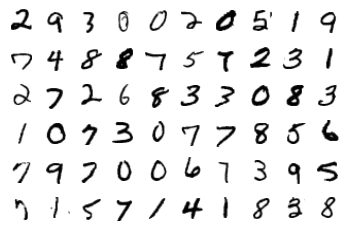

In [75]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [76]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=25, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(25),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5
         # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
    
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [77]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 26, 26]             135
       BatchNorm2d-2           [-1, 15, 26, 26]              30
              ReLU-3           [-1, 15, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]           1,350
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 25, 22, 22]           2,250
       BatchNorm2d-8           [-1, 25, 22, 22]              50
              ReLU-9           [-1, 25, 22, 22]               0
          Dropout-10           [-1, 25, 22, 22]               0
        MaxPool2d-11           [-1, 25, 11, 11]               0
           Conv2d-12           [-1, 20, 11, 11]             500

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [78]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [83]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.052154701203107834 Batch_id=468 Accuracy=94.78: 100%|██████████| 469/469 [00:18<00:00, 25.94it/s]



Test set: Average loss: 0.0680, Accuracy: 9805/10000 (98.05%)

EPOCH: 1


Loss=0.05748510733246803 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]



Test set: Average loss: 0.0435, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.15410216152668 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:17<00:00, 27.36it/s]



Test set: Average loss: 0.0364, Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.12633095681667328 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]



Test set: Average loss: 0.0364, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.036475446075201035 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]



Test set: Average loss: 0.0384, Accuracy: 9877/10000 (98.77%)

EPOCH: 5


Loss=0.05725044384598732 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]



Test set: Average loss: 0.0261, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.019235918298363686 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.0259, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.004118904005736113 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 27.28it/s]



Test set: Average loss: 0.0225, Accuracy: 9941/10000 (99.41%)

EPOCH: 8


Loss=0.03249698132276535 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]



Test set: Average loss: 0.0245, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.03662562742829323 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]



Test set: Average loss: 0.0263, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.005971478298306465 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]



Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.012492184527218342 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]



Test set: Average loss: 0.0197, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


Loss=0.014455846510827541 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]



Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.013307134620845318 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]



Test set: Average loss: 0.0207, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.035585928708314896 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]



Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)



In [84]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06610538810491562 Batch_id=468 Accuracy=94.46: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0626, Accuracy: 9826/10000 (98.26%)

EPOCH: 1


Loss=0.063600093126297 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:18<00:00, 25.97it/s]



Test set: Average loss: 0.0479, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.052584633231163025 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]



Test set: Average loss: 0.0447, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.010895967483520508 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]



Test set: Average loss: 0.0343, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.021630408242344856 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]



Test set: Average loss: 0.0292, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.04842367768287659 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]



Test set: Average loss: 0.0314, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.048574138432741165 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s]



Test set: Average loss: 0.0266, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.042730268090963364 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 27.81it/s]



Test set: Average loss: 0.0298, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.017615264281630516 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]



Test set: Average loss: 0.0255, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.019585443660616875 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]



Test set: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.01134481281042099 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]



Test set: Average loss: 0.0241, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.04822095111012459 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]



Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.04193206503987312 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0221, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.03909742459654808 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 24.85it/s]



Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.042610157281160355 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:19<00:00, 24.35it/s]



Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)



In [85]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08122318238019943 Batch_id=468 Accuracy=94.56: 100%|██████████| 469/469 [00:19<00:00, 24.48it/s]



Test set: Average loss: 0.0608, Accuracy: 9848/10000 (98.48%)

EPOCH: 1


Loss=0.028062159195542336 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]



Test set: Average loss: 0.0437, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.045947130769491196 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]



Test set: Average loss: 0.0498, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.06338333338499069 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]



Test set: Average loss: 0.0277, Accuracy: 9925/10000 (99.25%)

EPOCH: 4


Loss=0.06502926349639893 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]



Test set: Average loss: 0.0274, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.04450944438576698 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s]



Test set: Average loss: 0.0240, Accuracy: 9932/10000 (99.32%)

EPOCH: 6


Loss=0.021089499816298485 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s]



Test set: Average loss: 0.0220, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.045632705092430115 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]



Test set: Average loss: 0.0293, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.06473712623119354 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]



Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.020384931936860085 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s]



Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.004158003721386194 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]



Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.003466661088168621 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 25.77it/s]



Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.0140219172462821 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]



Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.01336562167853117 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]



Test set: Average loss: 0.0178, Accuracy: 9952/10000 (99.52%)

EPOCH: 14


Loss=0.009256711229681969 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]



Test set: Average loss: 0.0182, Accuracy: 9951/10000 (99.51%)



In [87]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.102927066385746 Batch_id=468 Accuracy=95.00: 100%|██████████| 469/469 [00:19<00:00, 24.34it/s]



Test set: Average loss: 0.0987, Accuracy: 9719/10000 (97.19%)

EPOCH: 1


Loss=0.010016442276537418 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:18<00:00, 25.99it/s]



Test set: Average loss: 0.0622, Accuracy: 9811/10000 (98.11%)

EPOCH: 2


Loss=0.030194001272320747 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.0417, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.02068055421113968 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]



Test set: Average loss: 0.0285, Accuracy: 9915/10000 (99.15%)

EPOCH: 4


Loss=0.00802414957433939 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]



Test set: Average loss: 0.0259, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Loss=0.011034253053367138 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]



Test set: Average loss: 0.0335, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


Loss=0.03463555872440338 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s]



Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)

EPOCH: 7


Loss=0.010441579855978489 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 8


Loss=0.03123791329562664 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]



Test set: Average loss: 0.0241, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.015740705654025078 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:19<00:00, 24.08it/s]



Test set: Average loss: 0.0213, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


Loss=0.16724365949630737 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]



Test set: Average loss: 0.0212, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.027434324845671654 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0223, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.024600831791758537 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]



Test set: Average loss: 0.0214, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.019647985696792603 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.012852228246629238 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:18<00:00, 24.98it/s]



Test set: Average loss: 0.0209, Accuracy: 9939/10000 (99.39%)



In [88]:

train_losses_numpy=[]
for a in train_losses:
  train_losses_numpy.append(a.cpu().item())

Text(0.5, 1.0, 'Test Accuracy')

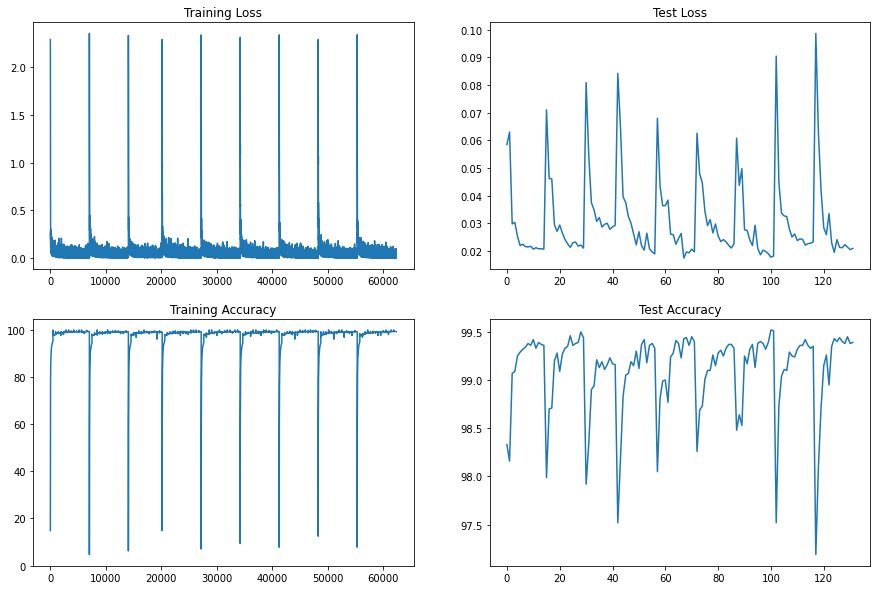

In [89]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_numpy)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [90]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.12422797083854675 Batch_id=468 Accuracy=94.97: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]



Test set: Average loss: 0.0583, Accuracy: 9820/10000 (98.20%)

EPOCH: 1


Loss=0.033297039568424225 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]



Test set: Average loss: 0.0575, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.033841632306575775 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0317, Accuracy: 9912/10000 (99.12%)

EPOCH: 3


Loss=0.016912134364247322 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]



Test set: Average loss: 0.0316, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.03569686785340309 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]



Test set: Average loss: 0.0272, Accuracy: 9924/10000 (99.24%)

EPOCH: 5


Loss=0.012540321797132492 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]



Test set: Average loss: 0.0249, Accuracy: 9930/10000 (99.30%)

EPOCH: 6


Loss=0.06250333040952682 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]



Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.014240294694900513 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.19it/s]



Test set: Average loss: 0.0221, Accuracy: 9938/10000 (99.38%)

EPOCH: 8


Loss=0.02080571837723255 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]



Test set: Average loss: 0.0224, Accuracy: 9941/10000 (99.41%)

EPOCH: 9


Loss=0.0034946149680763483 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]



Test set: Average loss: 0.0204, Accuracy: 9947/10000 (99.47%)

EPOCH: 10


Loss=0.032450899481773376 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]



Test set: Average loss: 0.0206, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.02709110639989376 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]



Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.006270139012485743 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]



Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.04793930426239967 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]



Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.019212860614061356 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]



Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)



In [96]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1190740093588829 Batch_id=468 Accuracy=94.70: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]



Test set: Average loss: 0.0639, Accuracy: 9829/10000 (98.29%)

EPOCH: 1


Loss=0.025152092799544334 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]



Test set: Average loss: 0.0433, Accuracy: 9893/10000 (98.93%)

EPOCH: 2


Loss=0.039255037903785706 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]



Test set: Average loss: 0.0424, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.052191153168678284 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]



Test set: Average loss: 0.0275, Accuracy: 9928/10000 (99.28%)

EPOCH: 4


Loss=0.05451017990708351 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]



Test set: Average loss: 0.0272, Accuracy: 9919/10000 (99.19%)

EPOCH: 5


Loss=0.0548589788377285 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 25.42it/s]



Test set: Average loss: 0.0269, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.02327394299209118 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]



Test set: Average loss: 0.0236, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.0369776226580143 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0263, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.02750408463180065 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test set: Average loss: 0.0253, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.022592760622501373 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]



Test set: Average loss: 0.0224, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.00690964562818408 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]



Test set: Average loss: 0.0204, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.017705654725432396 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]



Test set: Average loss: 0.0204, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.12917962670326233 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]



Test set: Average loss: 0.0210, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.0118867801502347 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]



Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.11184077709913254 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]



Test set: Average loss: 0.0205, Accuracy: 9945/10000 (99.45%)



In [97]:

train_losses_numpy=[]
for a in train_losses:
  train_losses_numpy.append(a.cpu().item())

Text(0.5, 1.0, 'Test Accuracy')

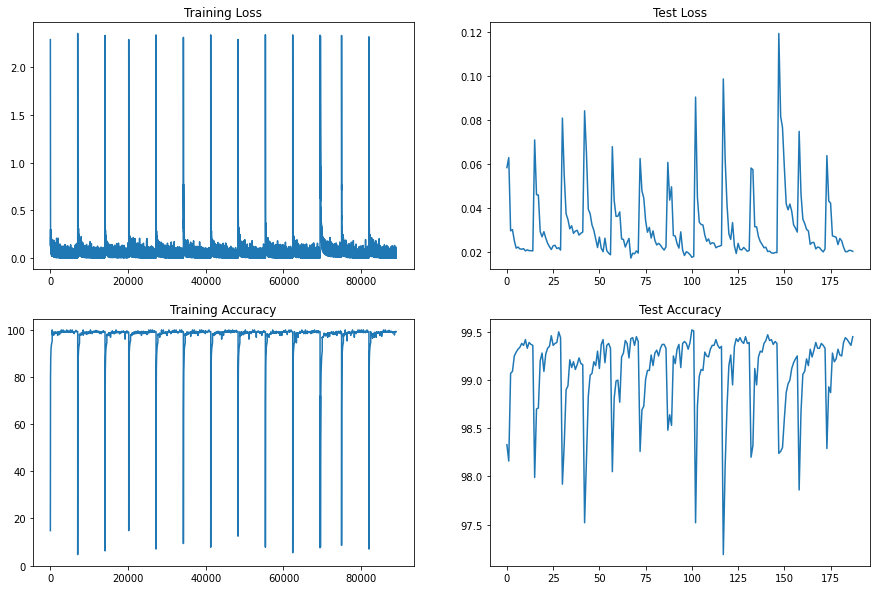

In [98]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_numpy)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")